The aim of this notebook is to evaluate the solute drag effect in a binary substitutional alloy using Cahn's solute drag model. The composition at steady state is evaluated by solving a second order linear differential equation. This profile is then used to calculate the drag pressure for a given velocity. Similar procedure is adopted for different velocities to obtain the variation of drag pressure with velocity.

The equation solved are:
Composition :

$$ D\frac{d^2c}{dx^2} + \frac{dc}{dx}(\frac{dD}{dx} + \frac{D}{kT}\frac{dE}{dx} + V) + \frac{c}{kT}(\frac{dD}{dx} \frac{dE}{dx} + D\frac{d^2E}{dx^2} = 0)$$

Solute drag:
$$ P_{sd} = \frac{1}{V_m} \int_{-\infty}^{\infty} (c - c_0)\frac{dE}{dx}dx $$

Diffusion is assumed to vary inside the interface i.e. high diffusion inside the boundary than the bulk, Energy barrier is assumed to be a sharp well with peak at the midpoint. 

In [7]:
import numpy as np

In [184]:
class SoluteDrag(object):
    """
    Defines an object to solve the composition 
    profile at steady state and solute drag force 
    for a given composition, diffusivity, energy profile.
    
    Parameters
    -----------
    composition : Initial bulk composition
    Energy : Interaction potential
    Diffusivity 
    Temperature

    """

    def __init__(self, nondimensionalize = True, **kwargs):
        
        if nondimensionalize:
            self.database = self.nondimensionalize( **kwargs)
        else :
            self.database = kwargs
        self.check_spacing() #Check the initialization of dx and npoints
        self.epeak = self.database['energy']
        self.vel = self.database['velocity']
        self.length = self.database['length']
        self.gbwidth = self.database['gb']
        self.npoints = self.database['Nseg'] + 1
        self.c0 = self.database['bulk_comp']
        self.dx = self.database['dx']
        
        self.ngbpoints = int(self.gbwidth//self.dx + 1)
        self.bidx = [(self.length - self.gbwidth)/(2*self.dx),(self.length - self.gbwidth)/(2*self.dx) + self.ngbpoints - 1]
        self.composition = np.ones(self.npoints)*self.c0
        
    
    def setup(self, param_array):
        """
        Setup the diffusivity, energy based on the input
        Params
        ------
        dict containing features to setup
        """ 
        for item in param_array:
            if self.database.get(item,False):
                param = self.database[item]
                if item == 'diff':
                    self.diffusivity = self.setup_diffusivity(param)
                    #print(self.diffusivity)
                if item == 'energy':
                    self.interaction = self.setup_energy(param)
                    #print(self.interaction)
    
    def setup_diffusivity(self, params):
        """
        Setup Diffusivity profile
        Params :
        A list containing [bulk_diffusivity, boundary difusivity]
        """
        dbulk, dboundary =  params[0], params[1]
        centre = self.npoints//2
        diff_array = np.ones(self.npoints)*dbulk
        gbseg = int(self.gbwidth//self.dx)
        diff_array[centre : centre + gbseg//2  ] = np.ones(gbseg//2)*dboundary + np.arange(gbseg//2)*((dbulk - dboundary)/(gbseg//2)) 
        diff_array[centre - gbseg//2 : centre ] = np.ones(gbseg//2)*dbulk + np.arange(gbseg//2)*((dboundary - dbulk)/(gbseg//2)) 
        
        return diff_array
    
    def setup_energy(self, params):
        """
        Setup Interaction Profile
        """
        if len(params) == 1:
            estart = 0.0
            epeak = params[0]
        else :
            estart = params[0]
            epeak = params[1]
        energy_array = np.ones(self.npoints)*estart
        centre = self.npoints//2
        gbseg = int(self.gbwidth//self.dx)
        energy_array[centre : centre + gbseg//2  ] = np.ones(gbseg//2)*epeak + np.arange(gbseg//2)*((estart - epeak)/(gbseg//2)) 
        energy_array[centre - gbseg//2 : centre ] = np.ones(gbseg//2)*estart + np.arange(gbseg//2)*((epeak - estart)/(gbseg//2))
        
        return energy_array
    
    
    def nondimensionalize(self, **kwargs):
        """
        Use non-dimensional parameters for solving the equation
        """
        nd_diff = kwargs['diff'][0] # Bulk Diffusivity
        nd_length = 1.E-12 #General length scale of interface
        nd_vel = nd_diff/nd_length # From the equation of flux
        
        print("Scaling Factors:")
        print("-------------------")
        print("Diffusivity = {}".format(nd_diff))
        print("Length = {}".format(nd_length))
        print("Velocity = {}".format(nd_vel))
        print("-------------------")
        #Substitute the values in dict
        if kwargs.get('diff',False):
            kwargs['diff'] = [x/nd_diff for x in kwargs['diff']]
        for item in ['length','gb','dx']:
            if kwargs.get(item,False):
                kwargs[item] /= nd_length
        if kwargs.get('velocity',False):   
            kwargs['velocity'] /= nd_vel

        
        return kwargs
    
    def check_spacing(self):
        Npoints,dx = self.database.get('Nseg',None), self.database.get('dx',None)
        if Npoints is None:
            self.database['Nseg'] = int(self.database['length']/self.database['dx'])
        elif dx is None:
            self.database['dx'] = self.database['length']/self.database['Nseg']
        else:
            if all(v is None for v in [dx,Npoints]):
                printf("Need atleast dx or Npoints")
            else:
                #Nsegments has the priority
                self.database['dx'] = self.database['length']/self.database['Nseg']
        
    def solve_direct(self):
    
        ##boundary condition
        self.composition[:2] = self.c0
        
        for k in range(2,self.npoints-1S):
            
            self.composition[k] = (2.*self.composition[k-1] - self.composition[k-2]) - (self.c1(k) + self.c2(k)) 
       
        
        return self.composition
    
    def c1(self, k):                                                                              
        return (self.composition[k-1] - self.composition[k-2])*((1. - self.diffusivity[k-2]/self.diffusivity[k-1] ) + (self.interaction[k-1] - self.interaction[k-2]) + self.vel*self.dx/self.diffusivity[k-1])
                                                                                       
    def c2(self, k):
        return self.composition[k-1]*((self.interaction[k-1] - self.interaction[k-2])*(1. - self.diffusivity[k-2]/self.diffusivity[k-1]) + self.interaction[k] + self.interaction[k-2] - 2.*self.interaction[k-1])
                                                                                       
                                                                                       
    def solute_drag(self, composition, bulk, energy, model = "Cahn"):
        """
        Evaluate the drag pressure based on the model chosen
        
        """
        pressure = 0.
        if model == "Cahn":
            for num in range(1,len(composition)):
                pressure += -1*(composition[num]-bulk)*(energy[num] - energy[num-1])
            return pressure
        else:
            return None
            

In [ ]:
class Visualization(object):
    def __init__(self):
        pass
    

# Analysis

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [185]:
# @hidden_cell
bulk_comp = 0.01 # In atomic percent
length = 2.E-8 # in nanometers
#dx = 5.E-12 # Grid Spacing
Nseg = 10000 #Number of segments
gb_width = 7.E-9 # in nanometers
vel = 2e-7

bulk_diff = 1E-11
boundary_diff = 1E-10
E0 = -20 #scaled

Lets take boundary diffusivity as the control parameter, such that bulk diffusivity is always 1. In other words, scaling factor for non dimensional diffusivities is bulk diffusivity. Length is also non-dimensionalized, where a non dimensional parameter is eliminated by fixing $\frac{l}{w}$ such that l is the lenth of the domain, and w is the width of the boundary. Here, scaling factor of Energy is taken as KT.  

# Testing

## Test - 1

A zero velocity should result in symmetric profile for a potential well.

## Initialization

In [186]:
# Use even length, Nseg and gb width for symmetric profile
#non-dimensionalized parameters
bulk_comp = 0.01 # In atomic percent
length = 20. 
#dx = 1 # Grid Spacing
Nseg = 500000
gb_width = 10.
vel = 0.0

bulk_diff = 1.
boundary_diff = 100.
E0 = -2. #scaled with KT

In [187]:
dict_params = {'diff':[bulk_diff, boundary_diff],
               'energy':[E0], 
               'velocity':vel,
               'length':length,
               'gb':gb_width,
               'Nseg':Nseg,
              'bulk_comp':bulk_comp}

sd = SoluteDrag(nondimensionalize = False, **dict_params)

In [188]:
sd.database

{'diff': [1.0, 100.0],
 'energy': [-2.0],
 'velocity': 0.0,
 'length': 20.0,
 'gb': 10.0,
 'Nseg': 500000,
 'bulk_comp': 0.01,
 'dx': 4e-05}

## Setup

In [189]:
sd.setup(['diff','energy'])
comp = sd.solve_direct()

## Visualization

[Text(0,0.5,'c/$c_0$'), Text(0.5,0,'x/$\\delta$')]

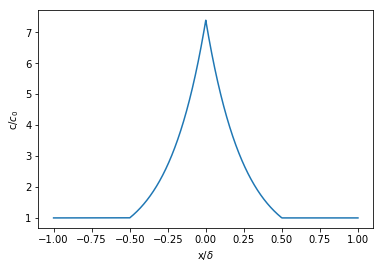

In [190]:
fig, ax = plt.subplots()
ax.plot(np.arange(-(Nseg+1)/2, (Nseg+1)/2)*sd.dx/gb_width,np.array(sd.composition/bulk_comp))
ax.set(xlabel = r'x/$\delta$', ylabel = r'c/$c_0$')

In [191]:
drag = sd.solute_drag(sd.composition, sd.c0, sd.interaction)
print(drag)

9.80435935309615e-07


## Test - 2 

For similar potential, high boundary diffusivity and finite velocity should yield unsymmetrical profile such that a peak exist before the migrating interface, resulting in solute drag.

In [192]:
##Initialization
# Use even length, Nseg and gb width for unsymmetric profile at a finite velocity
# High boundary Diffusivity
#non-dimensionalized parameters
bulk_comp = 0.01 # In atomic percent
length = 20. 
#dx = 1 # Grid Spacing
Nseg = 500000
gb_width = 10.
vel = 5.0

bulk_diff = 1.
boundary_diff = 100.
E0 = -2. #scaled with KT

In [193]:
## Setup and Solution
dict_params = {'diff':[bulk_diff, boundary_diff],
               'energy':[E0], 
               'velocity':vel,
               'length':length,
               'gb':gb_width,
               'Nseg':Nseg,
              'bulk_comp':bulk_comp}

sd = SoluteDrag(nondimensionalize = False, **dict_params)
sd.setup(['diff','energy'])
comp = sd.solve_direct()

[Text(0,0.5,'c/$c_0$'), Text(0.5,0,'x/$\\delta$')]

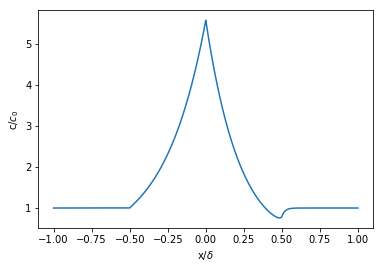

In [194]:
# Visualization
fig, ax = plt.subplots()
ax.plot(np.arange(-(Nseg+1)/2, (Nseg+1)/2)*sd.dx/gb_width,np.array(sd.composition/bulk_comp))
ax.set(xlabel = r'x/$\delta$', ylabel = r'c/$c_0$')

In [195]:
drag = sd.solute_drag(sd.composition, sd.c0, sd.interaction)
print(drag)

0.0075474693888791695


## Test - 3

Similar to Test 2, but low grain boundary diffusivity compared to bulk (inhibited solute diffusion) should lead to a different profile of concentration.

In [300]:
##Initialization
# Use even length, Nseg and gb width for unsymmetric profile at a finite velocity
# High boundary Diffusivity
#non-dimensionalized parameters
bulk_comp = 0.01 # In atomic percent
length = 20. 
#dx = 1 # Grid Spacing
Nseg = 500000
gb_width = 10.
vel = 500.0

bulk_diff = 1.
boundary_diff = 0.01
E0 = -2. #scaled with KT

In [301]:
## Setup and Solution
dict_params = {'diff':[bulk_diff, boundary_diff],
               'energy':[E0], 
               'velocity':vel,
               'length':length,
               'gb':gb_width,
               'Nseg':Nseg,
              'bulk_comp':bulk_comp}

sd = SoluteDrag(nondimensionalize = False, **dict_params)
sd.setup(['diff','energy'])
comp = sd.solve_direct()

In [310]:
sd.composition

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

[Text(0,0.5,'c/$c_0$'), Text(0.5,0,'x/$\\delta$')]

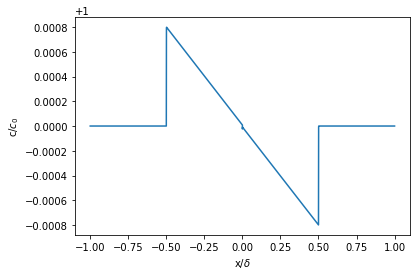

In [313]:
# Visualization
fig, ax = plt.subplots()
ax.plot(np.arange(-(Nseg+1)/2, (Nseg+1)/2)*sd.dx/gb_width,(sd.composition/bulk_comp))
ax.set(xlabel = r'x/$\delta$', ylabel = r'c/$c_0$')

In [270]:
drag = sd.solute_drag(sd.composition, sd.c0, sd.interaction)
print(drag)

1.6153866026088444e-05


Qualitatively, the behaviour of drag pressure and composition profile is as expected. Lets look at the variation of drag pressure with velocity for both the cases for fixed ratio of bulk and boundary diffusivity.

In [212]:
## helper function which takes in different velocity and returns drag pressure
def drag_velocity(vel, **dict_params):
    dict_params['velocity'] = vel
    sd = SoluteDrag(nondimensionalize = False, **dict_params)
    sd.setup(['diff','energy'])
    comp = sd.solve_direct()
    drag = sd.solute_drag(sd.composition, sd.c0, sd.interaction)
    return drag

## Case - 1 : High Boundary Diffusivity

In [250]:
## Bulk Diffusivity
bulk_diff = 1.
boundary_diff = 1.E2
E0 = -2

##Other Initial Parameters
bulk_comp = 0.01 # In atomic percent
length = 20. 
#dx = 1 # Grid Spacing
Nseg = 500000
gb_width = 10.

## Velocity
Velocity = np.linspace(1.0, 200.0, num = 100)

In [251]:
## Setup 
dict_params = {'diff':[bulk_diff, boundary_diff],
               'energy':[E0],
               'length':length,
                'gb':gb_width,
               'Nseg':Nseg,
              'bulk_comp':bulk_comp}

In [252]:
# Solve
drag = []
for vel in Velocity:
    drag.append(drag_velocity(vel, **dict_params))

[Text(0,0.5,'P'), Text(0.5,0,'v'), Text(0.5,1,'$D_{GB} = 10^2$')]

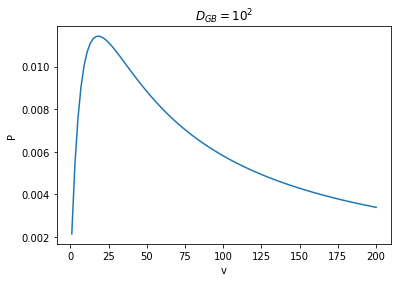

In [253]:
# Visualization
fig, ax = plt.subplots()
ax.plot(Velocity,drag)
ax.set(xlabel = r'v', ylabel = r'P', title = r'$D_{GB} = 10^2$')

For the clarity, a brief discussion of the scaling factors is described below:
* Energy, and therefore, drag pressure is scaled with KT. (More specifically, drag pressure by KT/ Molar Volume)
* Length is scaled such that the grain boundary width / current width is the scaling factor. 
* Diffusivity is scaled with bulk diffusivity
* Velocity is scaled with the ratio of diffusivity and length scaling i.e. 
$$ v = \frac{d}{\epsilon}$$

## Case II - Inhibited Solute diffusivity

In [262]:
## Bulk Diffusivity
bulk_diff = 1.
boundary_diff = 1.E-2
E0 = -2.

##Other Initial Parameters
bulk_comp = 0.01 # In atomic percent
length = 20. 
#dx = 1 # Grid Spacing
Nseg = 500000
gb_width = 10.

## Velocity
Velocity = np.linspace(1.0, 200.0, num = 100)

In [259]:
## Setup 
dict_params = {'diff':[bulk_diff, boundary_diff],
               'energy':[E0],
               'length':length,
                'gb':gb_width,
               'Nseg':Nseg,
              'bulk_comp':bulk_comp}

In [260]:
# Solve
drag = []
for vel in Velocity:
    drag.append(drag_velocity(vel, **dict_params))

[Text(0,0.5,'P'), Text(0.5,0,'v'), Text(0.5,1,'$D_GB = 10^{-2}$')]

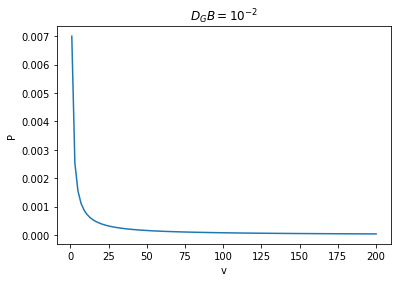

In [261]:
# Visualization
fig, ax = plt.subplots()
ax.plot(Velocity,drag)
ax.set(xlabel = r'v', ylabel = r'P', title = r'$D_GB = 10^{-2}$')